In [1]:
%pip install -q huggingface-hub==0.23.0
%pip install -q transformers==4.40.2
%pip install -q accelerate==0.30.1
%pip install -q sentencepiece==0.2.0
%pip install -q datasets==2.19.1
%pip install -q sentence-transformers==2.7.0
%pip install -q dspy-ai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.2/401.2 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.6/302.6 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 36.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 171.5/171.5 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 220.4/220.4 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.2/302.2 kB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━

In [ ]:
import os
import yaml
from google.colab import drive
from getpass import getpass

drive.mount('/content/drive')

In [ ]:
# Read YAML file
f_path = "/content/drive/MyDrive/GitHub/python-codebase/machine_learning/private_keys.yml"
with open(f_path, 'r') as stream:
    data_loaded = yaml.safe_load(stream)
os.environ['HF_API_TOKEN'] = data_loaded['HF_API_KEY']
os.environ['GITHUB_TOKEN'] = data_loaded['GITHUB_TOKEN']

# Introduction


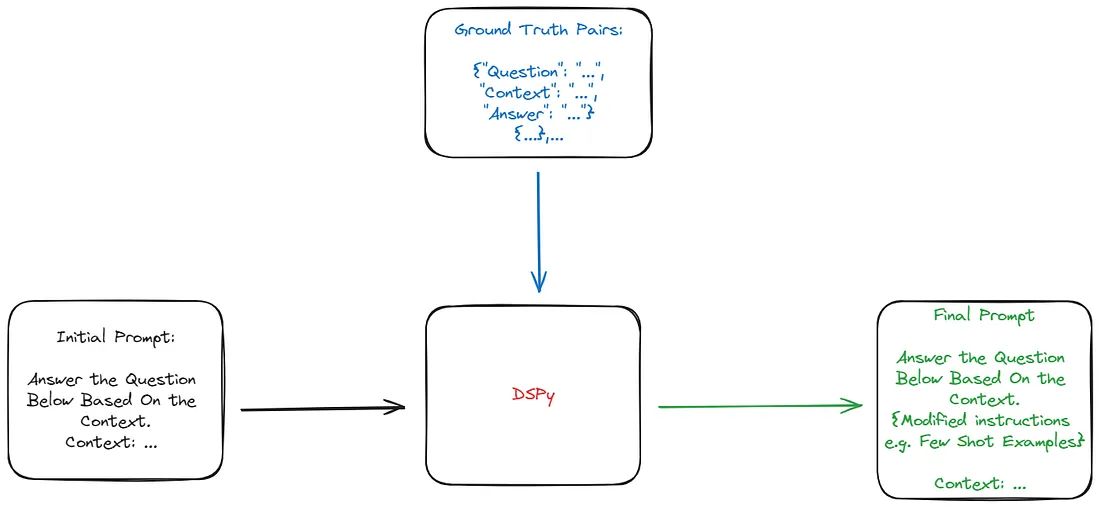

# References:
* https://medium.com/emalpha/dspy-does-it-live-up-to-the-hype-6e56c2c6e7a0
* https://dspy-docs.vercel.app/docs/deep-dive/teleprompter/bootstrap-fewshot

# 1. Example

In [17]:
import dspy

#turbo = dspy.OpenAI(model='gpt-3.5-turbo', max_tokens=250)
#dspy.settings.configure(lm=turbo)
#model_name = "HuggingFaceH4/zephyr-7b-beta"
model_name = "mistralai/Mistral-7B-Instruct-v0.2"
#model_name = "bigscience/bloomz-560m"
input_model = dspy.HFClientTGI(model=model_name, port=8080, url="http://localhost")
dspy.settings.configure(lm=input_model)

In [18]:
input_model("Esto es una prueba")

Failed to parse JSON response: 


Exception: Received invalid JSON response from server

In [3]:
# Load dataset
from dspy.datasets.gsm8k import GSM8K, gsm8k_metric

gms8k = GSM8K()
trainset, devset = gms8k.train, gms8k.dev

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/7473 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1319 [00:00<?, ? examples/s]

100%|██████████| 1319/1319 [00:00<00:00, 26908.14it/s]


In [10]:
id_sample = 0
print("question:", trainset[id_sample]['question'])
print("gold_reasoning:", trainset[id_sample]['gold_reasoning'])
print("answer:", trainset[id_sample]['answer'])

question: The result from the 40-item Statistics exam Marion and Ella took already came out. Ella got 4 incorrect answers while Marion got 6 more than half the score of Ella. What is Marion's score?
gold_reasoning: Ella's score is 40 items - 4 items = <<40-4=36>>36 items. Half of Ella's score is 36 items / 2 = <<36/2=18>>18 items. So, Marion's score is 18 items + 6 items = <<18+6=24>>24 items.
answer: 24


In [15]:
# Define a basic QA inline signature i.e. question->answer and pass it to ChainOfThought module, that applies necessary addition for CoT style prompting to the Signature
class CoT(dspy.Module):
    def __init__(self):
        super().__init__()
        self.prog = dspy.ChainOfThought("question -> answer")

    def forward(self, question):
        return self.prog(question=question)

In [5]:
# Evaluation: Evaluate the class that DSPy provides us. For the metric we'll use the gsm8k_metric that we imported above
from dspy.evaluate import Evaluate

NUM_THREADS = 5
evaluate = Evaluate(
    devset=devset[:],
    metric=gsm8k_metric,
    num_threads=NUM_THREADS,
    display_progress=True,
    display_table=False
)

In [16]:
# To evaluate the CoT pipeline we'll need to create an object of it and pass it as an arg to the evaluator call.

cot_baseline = CoT()
evaluate(cot_baseline, devset=devset[:])

Failed to parse JSON response: 
Failed to parse JSON response: 
Failed to parse JSON response: 
Failed to parse JSON response: Failed to parse JSON response: 
Failed to parse JSON response: 
Failed to parse JSON response: 


  0%|          | 0/300 [00:00<?, ?it/s]

Failed to parse JSON response: 

Failed to parse JSON response: 
Failed to parse JSON response: Failed to parse JSON response: 

Failed to parse JSON response:Failed to parse JSON response: 
Failed to parse JSON response: 
 
Failed to parse JSON response: 
Failed to parse JSON response: 
Failed to parse JSON response: Failed to parse JSON response: 
Failed to parse JSON response: Failed to parse JSON response: 
Failed to parse JSON response: 


Failed to parse JSON response: 
Failed to parse JSON response: 
Failed to parse JSON response: 
Failed to parse JSON response: 
Failed to parse JSON response: 
Failed to parse JSON response: 
Failed to parse JSON response: 
Failed to parse JSON response:Failed to parse JSON response: 
Failed to parse JSON response: 
 Failed to parse JSON response: 

Failed to parse JSON response: 
Failed to parse JSON response: 
Failed to parse JSON response: 
Failed to parse JSON response: Failed to parse JSON response: 
Failed to parse JSON response: 
Failed t

Exception: Received invalid JSON response from server